<a href="https://colab.research.google.com/github/HalgasAdrian/CS5230-Coursework/blob/main/HW2_KMEANS_and_Gaussian_Mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem 1: KMeans Theory**

A) prove that E step update on membership (\pi) achieves the minimum objective given the current centroids( \mu)

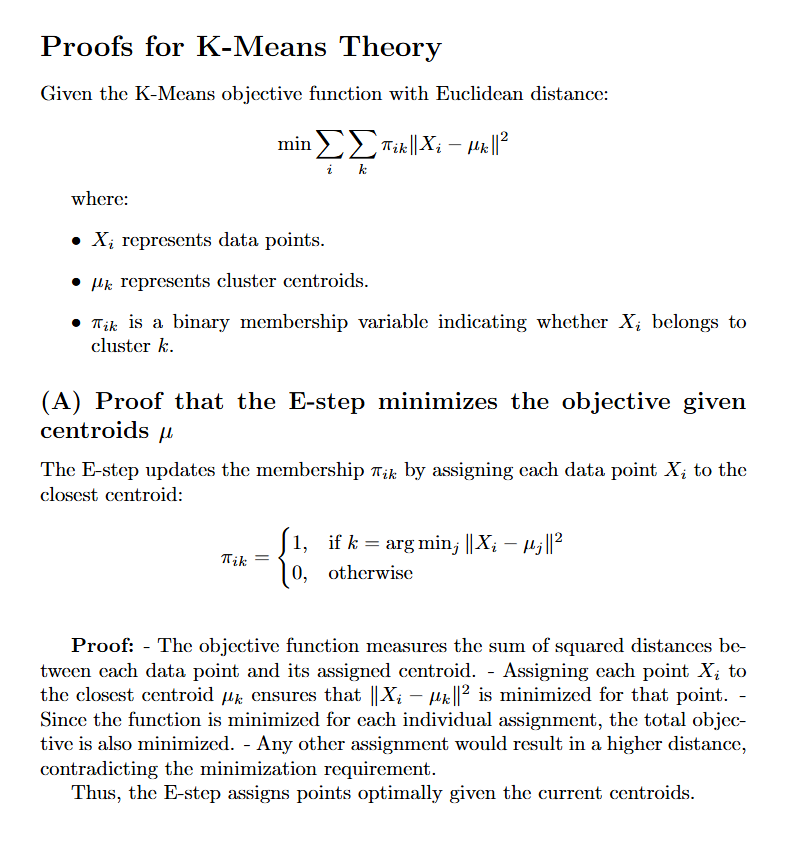

B) prove that M step update on centroids (\mu) achieves the minimum objective given the current memberships( \pi)

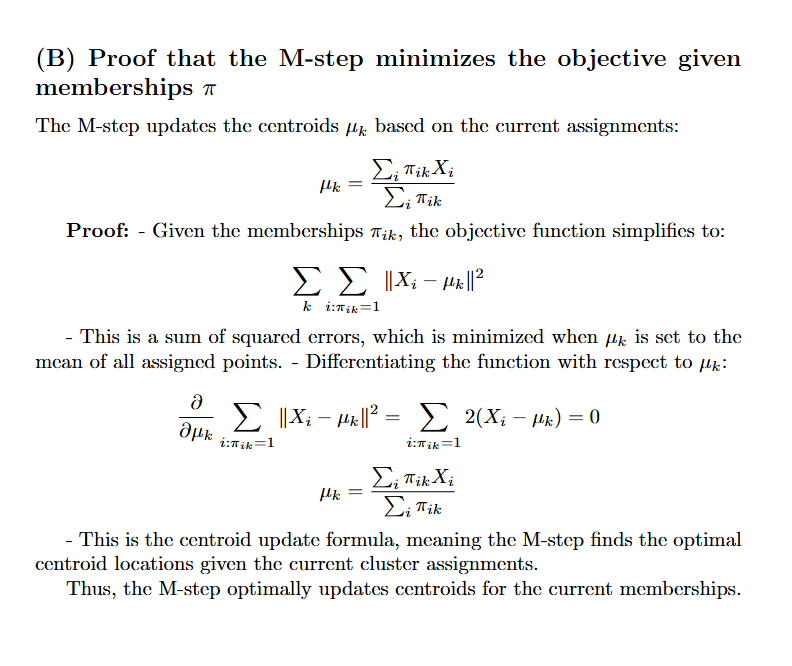

C) Explain why KMeans has to stop (converge), but not necessarily to the global minimum objective value.

K-Means iteratively reduces the objective function, which is bounded below. Each E-step and M-step guarentees a non-increasing objective value. However, K-means does not guarentee finding the golobal minimum because of a few reasons.

Those being that the objective function is non-convex, meaning that it may lead to multiple local minima and get trapped in a local minimum depending on centroids. Also, the choice of initial centroids influences convergence, setting up k-means poorly may lead to sub-optimal clusters. And finally, once a point is assigned to a cluster during the E-setp, it cannot go back to a previous configuration.

**Problem 2: KMeans on data**

Using Euclidian distance or dot product similarity (choose one per dataset, you can try other similarity metrics).

You can use a library for distance/similarity but you have to implement your own kmeans (EM steps, termination criteria etc).
For all three datasets, evaluate the KMeans objective for a higher K (for example double) or smaller K(for example half).
For all three datasets, evaluate external clustering performance using data labels and performance metrics Purity and Gini Index (see [A] book section 6.9.2).


A) Run KMeans on the MNIST Dataset, try K = 10

In [1]:
import os

base_url = 'https://web.archive.org/web/20220331230320/http://yann.lecun.com/exdb/mnist/'
files = [
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz',
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz'
]

# Directory to store MNIST data
os.makedirs('/content/mnist', exist_ok=True)

# Download each file
for file in files:
    url = f"{base_url}{file}"
    output_path = f"/content/mnist/{file}"
    !wget -O {output_path} {url}

print("All MNIST files downloaded.")

--2025-02-04 02:41:37--  https://web.archive.org/web/20220331230320/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving web.archive.org (web.archive.org)... 207.241.237.3
Connecting to web.archive.org (web.archive.org)|207.241.237.3|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://web.archive.org/web/20220331225332/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz [following]
--2025-02-04 02:41:37--  https://web.archive.org/web/20220331225332/http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Reusing existing connection to web.archive.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘/content/mnist/train-images-idx3-ubyte.gz’

/content/mnist/trai 100%[===================>]   9.45M  40.5MB/s    in 0.2s    

2025-02-04 02:41:39 (40.5 MB/s) - ‘/content/mnist/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-02-04 02:41:39--  https://web.archive

In [2]:
import gzip
import numpy as np

# Function to extract gzip files
def extract_gz(file_path, out_path):
    with gzip.open(file_path, 'rb') as f_in:
        with open(out_path, 'wb') as f_out:
            f_out.write(f_in.read())

# Extract MNIST files
mnist_dir = '/content/mnist'
for file in files:
    gz_path = os.path.join(mnist_dir, file)
    out_path = gz_path.replace('.gz', '')
    extract_gz(gz_path, out_path)

print("All MNIST files extracted.")

# Function to parse MNIST image files
def load_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        f.read(16)  # Skip header
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(-1, 28, 28)

# Function to parse MNIST label files
def load_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        f.read(8)  # Skip header
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

# Load training and test data
X_train_mnist = load_mnist_images('/content/mnist/train-images-idx3-ubyte')
y_train_mnist = load_mnist_labels('/content/mnist/train-labels-idx1-ubyte')
X_test_mnist = load_mnist_images('/content/mnist/t10k-images-idx3-ubyte')
y_test_mnist = load_mnist_labels('/content/mnist/t10k-labels-idx1-ubyte')

print("MNIST data successfully loaded.")

All MNIST files extracted.
MNIST data successfully loaded.


KMeans from scratch

In [3]:
import numpy as np

class KMeans:
    def __init__(self, n_clusters=10, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels = None

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize centroids randomly
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

        for i in range(self.max_iter):
            # Assign clusters
            distances = self._compute_distances(X)
            self.labels = np.argmin(distances, axis=1)

            # Update centroids
            new_centroids = np.array([X[self.labels == k].mean(axis=0) for k in range(self.n_clusters)])

            # Check for convergence
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break

            self.centroids = new_centroids

    def _compute_distances(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            distances[:, k] = np.linalg.norm(X - self.centroids[k], axis=1)
        return distances

    def predict(self, X):
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)

Kmeans on MNIST Dataset with K = 10

In [4]:
# Flatten the MNIST images
X_train_mnist_flat = X_train_mnist.reshape(X_train_mnist.shape[0], -1)

# Normalize the data
X_train_mnist_flat = X_train_mnist_flat / 255.0

# Run KMeans
kmeans_mnist = KMeans(n_clusters=10)
kmeans_mnist.fit(X_train_mnist_flat)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_mnist = kmeans_objective(X_train_mnist_flat, kmeans_mnist.centroids, kmeans_mnist.labels)
print(f"KMeans Objective for MNIST (K=10): {objective_mnist}")

KMeans Objective for MNIST (K=10): 2353218.91742778


In [5]:
from sklearn.metrics import confusion_matrix

def purity_score(y_true, y_pred):
    confusion_mat = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(confusion_mat, axis=0)) / np.sum(confusion_mat)

def gini_index(y_true, y_pred):
    contingency = confusion_matrix(y_true, y_pred)
    cluster_sizes = np.sum(contingency, axis=0)

    # Handle empty clusters and division by zero
    valid_clusters = cluster_sizes > 0
    if np.sum(valid_clusters) == 0:
        return 1.0  # Return worst case when all clusters are empty

    # Calculate purities only for valid clusters
    cluster_purities = np.zeros_like(cluster_sizes, dtype=np.float64)
    cluster_purities[valid_clusters] = np.amax(contingency[:, valid_clusters], axis=0) / cluster_sizes[valid_clusters]

    # Calculate weighted Gini index
    total_samples = np.sum(cluster_sizes)
    weights = cluster_sizes[valid_clusters] / total_samples
    gini = 1 - np.sum(weights * (cluster_purities[valid_clusters] ** 2))

    return np.clip(gini, 0.0, 1.0)

purity_mnist = purity_score(y_train_mnist, kmeans_mnist.labels)
gini_mnist = gini_index(y_train_mnist, kmeans_mnist.labels)

print(f"Purity for MNIST (K=10): {purity_mnist}")
print(f"Gini Index for MNIST (K=10): {gini_mnist}")

Purity for MNIST (K=10): 0.5778
Gini Index for MNIST (K=10): 0.6244668166508232


MNIST KMEANS K=20 with external clustering performance.

In [6]:
# Run KMeans
kmeans_mnist = KMeans(n_clusters=20)
kmeans_mnist.fit(X_train_mnist_flat)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_mnist = kmeans_objective(X_train_mnist_flat, kmeans_mnist.centroids, kmeans_mnist.labels)
print(f"KMeans Objective for MNIST (K=20): {objective_mnist}")

purity_mnist = purity_score(y_train_mnist, kmeans_mnist.labels)
gini_mnist = gini_index(y_train_mnist, kmeans_mnist.labels)

print(f"Purity for MNIST (K=20): {purity_mnist}")
print(f"Gini Index for MNIST (K=20): {gini_mnist}")

KMeans Objective for MNIST (K=20): 2115879.6999093303
Purity for MNIST (K=20): 0.70205
Gini Index for MNIST (K=20): 0.47186613545180833


MNIST KMEANS K=5 with external clustering performance.

In [7]:
# Run KMeans
kmeans_mnist = KMeans(n_clusters=5)
kmeans_mnist.fit(X_train_mnist_flat)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_mnist = kmeans_objective(X_train_mnist_flat, kmeans_mnist.centroids, kmeans_mnist.labels)
print(f"KMeans Objective for MNIST (K=5): {objective_mnist}")

purity_mnist = purity_score(y_train_mnist, kmeans_mnist.labels)
gini_mnist = gini_index(y_train_mnist, kmeans_mnist.labels)

print(f"Purity for MNIST (K=5): {purity_mnist}")
print(f"Gini Index for MNIST (K=5): {gini_mnist}")

KMeans Objective for MNIST (K=5): 2605960.3633342613
Purity for MNIST (K=5): 0.4524
Gini Index for MNIST (K=5): 0.7690480471040737


B) run KMeans on the FASHION Dataset, try K=10

First we must load and prepare the data.

In [8]:
# Create directory
!mkdir -p /content/fashion-mnist

# Download files directly to the target directory
!wget -P /content/fashion-mnist https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz
!wget -P /content/fashion-mnist https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz
!wget -P /content/fashion-mnist https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
!wget -P /content/fashion-mnist https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz

# Extract files
import gzip
import shutil

for gz_file in ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
                't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']:
    with gzip.open(f'/content/fashion-mnist/{gz_file}', 'rb') as f_in:
        with open(f'/content/fashion-mnist/{gz_file[:-3]}', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

print("Files successfully downloaded and extracted!")

--2025-02-04 02:56:09--  https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz [following]
--2025-02-04 02:56:10--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/train-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [application/octet-stream]
Saving to: ‘/content/fashion-mnist/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25

In [9]:
import numpy as np
import os

def load_fashion(path, kind='train'):
    """Load Fashion MNIST data from path"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                             offset=16).reshape(len(labels), 784)

    return images.reshape(-1, 28, 28), labels

# Load the data
try:
    X_train_fashion, y_train_fashion = load_fashion('/content/fashion-mnist', kind='train')
    X_test_fashion, y_test_fashion = load_fashion('/content/fashion-mnist', kind='t10k')
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error: {e}")

Data loaded successfully!


Now with our data loaded we can run KMEANS on the FASHION dataset.

In [10]:
# Flatten the Fashion images
X_train_fashion_flat = X_train_fashion.reshape(X_train_fashion.shape[0], -1)

# Normalize the data
X_train_fashion_flat = X_train_fashion_flat / 255.0

# Run KMeans
kmeans_fashion = KMeans(n_clusters=10)
kmeans_fashion.fit(X_train_fashion_flat)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_fashion = kmeans_objective(X_train_fashion_flat, kmeans_fashion.centroids, kmeans_fashion.labels)
print(f"KMeans Objective for FASHION (K=10): {objective_fashion}")

KMeans Objective for FASHION (K=10): 1906652.392145225


In [11]:
from sklearn.metrics import confusion_matrix

purity_fashion = purity_score(y_train_fashion, kmeans_fashion.labels)
gini_fashion = gini_index(y_train_fashion, kmeans_fashion.labels)

print(f"Purity for MNIST (K=10): {purity_fashion}")
print(f"Gini Index for MNIST (K=10): {gini_fashion}")

Purity for MNIST (K=10): 0.5536666666666666
Gini Index for MNIST (K=10): 0.6540341663764815


FASHION KMEANS K=20 with external clustering performance.

In [12]:
# Run KMeans
kmeans_fashion = KMeans(n_clusters=20)
kmeans_fashion.fit(X_train_fashion_flat)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_fashion = kmeans_objective(X_train_fashion_flat, kmeans_fashion.centroids, kmeans_fashion.labels)
print(f"KMeans Objective for FASHION (K=20): {objective_fashion}")

purity_fashion = purity_score(y_train_fashion, kmeans_fashion.labels)
gini_fashion = gini_index(y_train_fashion, kmeans_fashion.labels)

print(f"Purity for MNIST (K=20): {purity_fashion}")
print(f"Gini Index for MNIST (K=20): {gini_fashion}")

KMeans Objective for FASHION (K=20): 1607457.4732886902
Purity for MNIST (K=20): 0.6597833333333334
Gini Index for MNIST (K=20): 0.5137265218084688


FASHION KMEANS K=5 with external clustering performance.

In [13]:
# Run KMeans
kmeans_fashion = KMeans(n_clusters=5)
kmeans_fashion.fit(X_train_fashion_flat)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_fashion = kmeans_objective(X_train_fashion_flat, kmeans_fashion.centroids, kmeans_fashion.labels)
print(f"KMeans Objective for FASHION (K=5): {objective_fashion}")

purity_fashion = purity_score(y_train_fashion, kmeans_fashion.labels)
gini_fashion = gini_index(y_train_fashion, kmeans_fashion.labels)

print(f"Purity for MNIST (K=5): {purity_fashion}")
print(f"Gini Index for MNIST (K=5): {gini_fashion}")

KMeans Objective for FASHION (K=5): 2352605.7771383133
Purity for MNIST (K=5): 0.41083333333333333
Gini Index for MNIST (K=5): 0.8211061368621794


C) run KMeans on the 20NG Dataset, try K=20

Load and prepare the data.

In [14]:
# Download the 20 Newsgroups dataset
!wget -O /content/20news-bydate.tar.gz 'http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz'

# Extract the dataset
import tarfile
import os

data_dir = '/content/20news-bydate'
with tarfile.open('/content/20news-bydate.tar.gz', 'r:gz') as tar:
    tar.extractall(path=data_dir)

print(f"Dataset extracted to {data_dir}")

--2025-02-04 03:10:33--  http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz
Resolving qwone.com (qwone.com)... 173.48.205.131
Connecting to qwone.com (qwone.com)|173.48.205.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14464277 (14M) [application/x-gzip]
Saving to: ‘/content/20news-bydate.tar.gz’

/content/20news-byd 100%[===================>]  13.79M  12.9MB/s    in 1.1s    

2025-02-04 03:10:34 (12.9 MB/s) - ‘/content/20news-bydate.tar.gz’ saved [14464277/14464277]

Dataset extracted to /content/20news-bydate


Note on TF-IDF Vectorization:
Term Frequency-Inverse Document Frequency is a text representation technique that evaluates how importat a word is to a document relative to a corpus.

Term Frequency (TF) = (word count in doc) / (total words in doc) - measures local importance of a word

Inverse document frequency (IDF) = log(total docs / docs containing word) - penalizes words common across many docs

TF-IDF = TF * IDF - final importance score for each word

TfidVectorizer automatically applies L2 Normalization to our output vectors.


In [15]:
# Parse the dataset
import os
import tarfile
from sklearn.feature_extraction.text import TfidfVectorizer

data_dir = '/content/20news-bydate'

# Check if the directory exists, if not, download and extract
train_dir = os.path.join(data_dir, '20news-bydate-train')
if not os.path.exists(train_dir):
    print("Downloading 20 Newsgroups dataset...")
    !wget -O /content/20news-bydate.tar.gz 'http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz'

    print("Extracting dataset...")
    with tarfile.open('/content/20news-bydate.tar.gz', 'r:gz') as tar:
        tar.extractall(path=data_dir)

    print(f"Dataset extracted to {data_dir}")
def parse_20newsgroups(data_dir):
    texts, labels = [], []
    label_names = sorted(os.listdir(data_dir))

    for label_idx, label_name in enumerate(label_names):
        label_path = os.path.join(data_dir, label_name)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                file_path = os.path.join(label_path, file_name)
                with open(file_path, 'r', errors='ignore') as f:
                    texts.append(f.read())
                    labels.append(label_idx)

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X = vectorizer.fit_transform(texts).toarray()

    return X, labels, vectorizer.get_feature_names_out()

# Process the dataset
X_20NG, y_20NG, feature_names_20NG = parse_20newsgroups(os.path.join(data_dir, '20news-bydate-train'))
print(f"20NG Dataset: {len(X_20NG)} samples, {len(feature_names_20NG)} features.")

20NG Dataset: 11314 samples, 5000 features.


Now with 20 NewsGroups loaded we can run our KMEANS with K = 20.

In [16]:
# Run KMeans
kmeans_20NG = KMeans(n_clusters=20)
kmeans_20NG.fit(X_20NG)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_20NG = kmeans_objective(X_20NG, kmeans_20NG.centroids, kmeans_20NG.labels)
print(f"KMeans Objective for 20NG (K=20): {objective_20NG}")

KMeans Objective for 20NG (K=20): 10604.217794645083


In [17]:
from sklearn.metrics import confusion_matrix

purity_20NG = purity_score(y_20NG, kmeans_20NG.labels)
gini_20NG = gini_index(y_20NG, kmeans_20NG.labels)

print(f"Purity for MNIST (K=20): {purity_20NG}")
print(f"Gini Index for MNIST (K=20): {gini_20NG}")

Purity for MNIST (K=20): 0.36918861587413826
Gini Index for MNIST (K=20): 0.7925432611353883


20NG KMEANS with K = 40 with external clustering performance.

In [18]:
# Run KMeans
kmeans_20NG = KMeans(n_clusters=40)
kmeans_20NG.fit(X_20NG)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_20NG = kmeans_objective(X_20NG, kmeans_20NG.centroids, kmeans_20NG.labels)
print(f"KMeans Objective for 20NG (K=40): {objective_20NG}")

purity_20NG = purity_score(y_20NG, kmeans_20NG.labels)
gini_20NG = gini_index(y_20NG, kmeans_20NG.labels)

print(f"Purity for MNIST (K=40): {purity_20NG}")
print(f"Gini Index for MNIST (K=40): {gini_20NG}")

KMeans Objective for 20NG (K=40): 10309.533941378111
Purity for MNIST (K=40): 0.4071946261269224
Gini Index for MNIST (K=40): 0.7430578187890123


20NG KMEANS with K = 10 with external clustering performance.

In [19]:
# Run KMeans
kmeans_20NG = KMeans(n_clusters=10)
kmeans_20NG.fit(X_20NG)

# Evaluate the KMeans objective
def kmeans_objective(X, centroids, labels):
    return np.sum([np.linalg.norm(X[labels == k] - centroids[k])**2 for k in range(centroids.shape[0])])

objective_20NG = kmeans_objective(X_20NG, kmeans_20NG.centroids, kmeans_20NG.labels)
print(f"KMeans Objective for 20NG (K=10): {objective_20NG}")

purity_20NG = purity_score(y_20NG, kmeans_20NG.labels)
gini_20NG = gini_index(y_20NG, kmeans_20NG.labels)

print(f"Purity for MNIST (K=10): {purity_20NG}")
print(f"Gini Index for MNIST (K=10): {gini_20NG}")

KMeans Objective for 20NG (K=10): 10779.45928716872
Purity for MNIST (K=10): 0.28893406399151494
Gini Index for MNIST (K=10): 0.8638909658248799


D) run soft Kmeans for MNIST dataset, use K=10. You can try beta=0.1, beta=1, beta=10. Evaluate performance.

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix

class SoftKMeans:
    def __init__(self, n_clusters=10, max_iter=100, tol=1e-4, beta=1.0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.beta = beta
        self.centroids = None
        self.responsibilities = None

    def _compute_distances(self, X):
        """Calculate Euclidean distances between data points and centroids"""
        return np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)

    def _compute_responsibilities(self, distances):
        """Convert distances to probabilities using softmax with temperature parameter beta"""
        scaled_dist = -self.beta * distances
        shifted_scaled = scaled_dist - np.max(scaled_dist, axis=1, keepdims=True)  # For numerical stability
        exp_values = np.exp(shifted_scaled)
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def fit(self, X):
        # Initialize centroids randomly
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            # E-step: Compute responsibilities
            distances = self._compute_distances(X)
            responsibilities = self._compute_responsibilities(distances)

            # M-step: Update centroids
            new_centroids = np.zeros_like(self.centroids)
            for k in range(self.n_clusters):
                weight_sum = np.sum(responsibilities[:, k])
                if weight_sum < 1e-8:  # Handle empty clusters more robustly
                    new_centroids[k] = X[np.random.choice(X.shape[0])]
                else:
                    new_centroids[k] = np.sum(X * responsibilities[:, k, np.newaxis], axis=0) / weight_sum

            # Check convergence
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
            self.centroids = new_centroids

        # Store final responsibilities
        self.responsibilities = self._compute_responsibilities(self._compute_distances(X))

    def predict(self, X):
        """Assign to cluster with highest responsibility"""
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)

# Experiments with different beta values
betas = [0.1, 1, 10]
for beta in betas:
    print(f"\nRunning Soft K-Means with β={beta}")
    skm = SoftKMeans(n_clusters=10, beta=beta, max_iter=100)
    skm.fit(X_train_mnist_flat)

    # Get cluster assignments
    cluster_labels = skm.predict(X_train_mnist_flat)

    # Calculate metrics
    purity = purity_score(y_train_mnist, cluster_labels)
    gini = gini_index(y_train_mnist, cluster_labels)

    print(f"β={beta}:")
    print(f"Purity = {purity:.4f}")
    print(f"Gini Index = {gini:.4f}")


Running Soft K-Means with β=0.1
β=0.1:
Purity = 0.3315
Gini Index = 0.8853

Running Soft K-Means with β=1
β=1:
Purity = 0.2095
Gini Index = 0.9560

Running Soft K-Means with β=10
β=10:
Purity = 0.5902
Gini Index = 0.6170


**Problem 3: Gaussian Mixture on toy data**

You are required to implemet the main EM loop, but can use math API/functions provided by your language to calculate normal densities, covariance matrix, etc.


A) The gaussian 2-dim data on file  2gaussian.txt  has been generated  using a mixture  of  two Gaussians, each  2-dim, with the parameters below. Run the EM algorithm with random initial values to recover the parameters.

mean_1 [3,3]); cov_1 = [[1,0],[0,3]]; n1=2000 points

mean_2 =[7,4]; cov_2 = [[1,0.5],[0.5,1]]; ; n2=4000 points

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [22]:
# Load data
url = 'https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/HW2/2gaussian.txt'
data = np.loadtxt(url)
print(f"Loaded data shape: {data.shape}")

Loaded data shape: (6000, 2)


In [23]:
# Initialize parameters
K = 2
n_samples = data.shape[0]

# Random initialization
np.random.seed(42)
means = data[np.random.choice(n_samples, K, replace=False)]
covariances = [np.eye(2) for _ in range(K)]
weights = np.ones(K) / K

# EM parameters
max_iter = 100
tolerance = 1e-6
log_likelihood_prev = 0

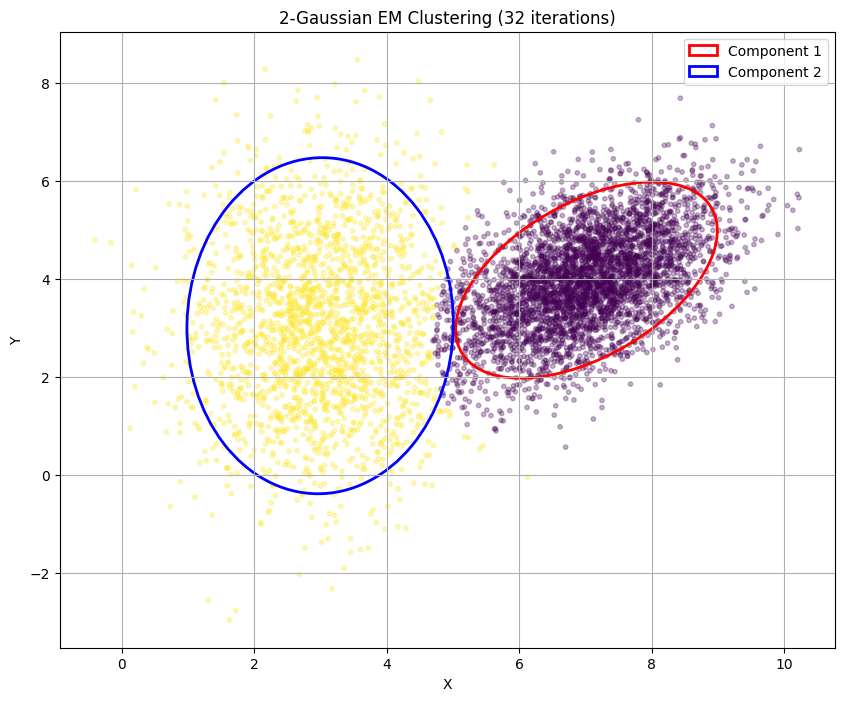

In [24]:
# Run EM algorithm
for iteration in range(max_iter):
    # E-step
    responsibilities = np.zeros((n_samples, K))
    for k in range(K):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(
            data, mean=means[k], cov=covariances[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

    # M-step
    Nk = responsibilities.sum(axis=0)
    weights = Nk / n_samples
    means = np.array([np.sum(responsibilities[:, k:k+1] * data, axis=0) / Nk[k]
                     for k in range(K)])
    covariances = []
    for k in range(K):
        diff = data - means[k]
        cov = (responsibilities[:, k] * diff.T) @ diff / Nk[k]
        covariances.append(cov)

    # Convergence check
    log_likelihood = np.sum(np.log(np.sum(
        [weights[k] * multivariate_normal.pdf(data, means[k], covariances[k])
         for k in range(K)], axis=0)))
    if np.abs(log_likelihood - log_likelihood_prev) < tolerance:
        break
    log_likelihood_prev = log_likelihood

# Plotting
plt.figure(figsize=(10, 8))
colors = ['red', 'blue']

# Plot data points
plt.scatter(data[:, 0], data[:, 1], alpha=0.3,
            c=np.argmax(responsibilities, axis=1), cmap='viridis', s=10)

# Plot covariance ellipses
for k in range(K):
    eigvals, eigvecs = np.linalg.eigh(covariances[k])
    angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    width, height = 2 * 2 * np.sqrt(eigvals)

    plt.gca().add_patch(Ellipse(
        (means[k][0], means[k][1]),
        width=width,
        height=height,
        angle=angle,
        edgecolor=colors[k],
        facecolor='none',
        linewidth=2,
        label=f'Component {k+1}'))

plt.title(f'2-Gaussian EM Clustering ({iteration+1} iterations)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# Print learned parameters
print("Learned parameters:")
for k in range(K):
    print(f"Component {k+1}:")
    print(f"  Weight: {weights[k]:.4f}")
    print(f"  Mean: {means[k].round(2)}")
    print(f"  Covariance:\n{np.round(covariances[k], 2)}\n")

# True parameters
true_params = [
    {'mean': [3, 3], 'cov': [[1, 0], [0, 3]], 'n': 2000},
    {'mean': [7, 4], 'cov': [[1, 0.5], [0.5, 1]], 'n': 4000}
]

print("True parameters:")
total_samples = 2000 + 4000
for k in range(K):
    print(f"Component {k+1}:")
    print(f"  Weight: {true_params[k]['n']/total_samples:.4f}")
    print(f"  Mean: {true_params[k]['mean']}")
    print(f"  Covariance:\n{np.array(true_params[k]['cov'])}\n")

B) Same problem for 2-dim data on file 3gaussian.txt , generated using a mixture of three Gaussians. Verify your  findings against the true parameters used generate the data below.

mean_1 = [3,3] ; cov_1 = [[1,0],[0,3]]; n1=2000

mean_2 = [7,4] ; cov_2 = [[1,0.5],[0.5,1]] ; n2=3000

mean_3 = [5,7] ; cov_3 = [[1,0.2],[0.2,1]]    ); n3=5000

In [25]:
# Load 3-gaussian data
url = 'https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/HW2/3gaussian.txt'
data = np.loadtxt(url)
print(f"Loaded data shape: {data.shape}")

Learned parameters:
Component 1:
  Weight: 0.6652
  Mean: [7.01 3.98]
  Covariance:
[[0.97 0.5 ]
 [0.5  1.  ]]

Component 2:
  Weight: 0.3348
  Mean: [2.99 3.05]
  Covariance:
[[1.01 0.03]
 [0.03 2.94]]

True parameters:
Component 1:
  Weight: 0.3333
  Mean: [3, 3]
  Covariance:
[[1 0]
 [0 3]]

Component 2:
  Weight: 0.6667
  Mean: [7, 4]
  Covariance:
[[1.  0.5]
 [0.5 1. ]]

Loaded data shape: (10000, 2)


In [26]:
# EM Algorithm Implementation
K = 3  # Now three components
n_samples = data.shape[0]

# Initialize parameters
np.random.seed(42)
means = data[np.random.choice(n_samples, K, replace=False)]
covariances = [np.eye(2) for _ in range(K)]
weights = np.ones(K) / K

# EM parameters
max_iter = 100
tolerance = 1e-6
log_likelihood_prev = 0

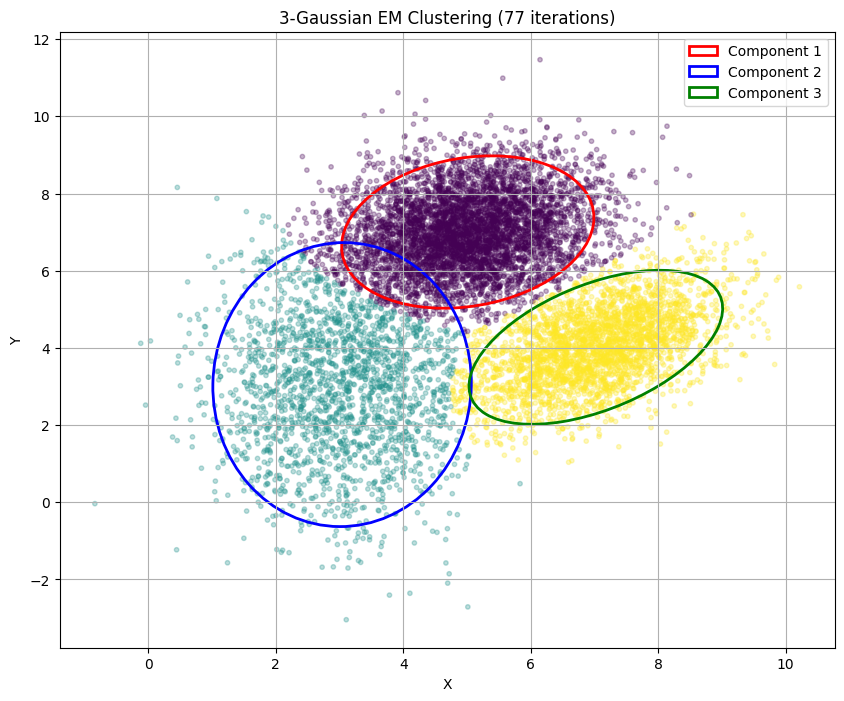

Learned parameters:
Component 1:
  Weight: 0.4960
  Mean: [5.01 7.  ]
  Covariance:
[[0.98 0.19]
 [0.19 0.97]]

Component 2:
  Weight: 0.2056
  Mean: [3.04 3.05]
  Covariance:
[[1.03 0.03]
 [0.03 3.38]]

Component 3:
  Weight: 0.2984
  Mean: [7.02 4.02]
  Covariance:
[[0.99 0.5 ]
 [0.5  1.  ]]

True parameters:
Component 1:
  Weight: 0.20
  Mean: [3, 3]
  Covariance:
[[1 0]
 [0 3]]

Component 2:
  Weight: 0.30
  Mean: [7, 4]
  Covariance:
[[1.  0.5]
 [0.5 1. ]]

Component 3:
  Weight: 0.50
  Mean: [5, 7]
  Covariance:
[[1.  0.2]
 [0.2 1. ]]



In [27]:
# Run EM algorithm
for iteration in range(max_iter):
    # E-step
    responsibilities = np.zeros((n_samples, K))
    for k in range(K):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(
            data, mean=means[k], cov=covariances[k])
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

    # M-step
    Nk = responsibilities.sum(axis=0)
    weights = Nk / n_samples
    means = np.array([np.sum(responsibilities[:, k:k+1] * data, axis=0) / Nk[k]
                     for k in range(K)])
    covariances = []
    for k in range(K):
        diff = data - means[k]
        cov = (responsibilities[:, k] * diff.T) @ diff / Nk[k]
        covariances.append(cov)

    # Convergence check
    log_likelihood = np.sum(np.log(np.sum(
        [weights[k] * multivariate_normal.pdf(data, means[k], covariances[k])
         for k in range(K)], axis=0)))
    if np.abs(log_likelihood - log_likelihood_prev) < tolerance:
        break
    log_likelihood_prev = log_likelihood

# Plotting
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green']

# Plot data points
plt.scatter(data[:, 0], data[:, 1], alpha=0.3,
            c=np.argmax(responsibilities, axis=1), cmap='viridis', s=10)

# Plot covariance ellipses (fixed version)
for k in range(K):
    eigvals, eigvecs = np.linalg.eigh(covariances[k])
    angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
    width, height = 2 * 2 * np.sqrt(eigvals)

    plt.gca().add_patch(Ellipse(
        (means[k][0], means[k][1]),
        width=width,
        height=height,
        angle=angle,
        edgecolor=colors[k],
        facecolor='none',
        linewidth=2,
        label=f'Component {k+1}'))

plt.title(f'3-Gaussian EM Clustering ({iteration+1} iterations)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# Print learned parameters
print("Learned parameters:")
for k in range(K):
    print(f"Component {k+1}:")
    print(f"  Weight: {weights[k]:.4f}")
    print(f"  Mean: {means[k].round(2)}")
    print(f"  Covariance:\n{np.round(covariances[k], 2)}\n")

# True parameters
true_params = [
    {'mean': [3,3], 'cov': [[1,0],[0,3]], 'n':2000},
    {'mean': [7,4], 'cov': [[1,0.5],[0.5,1]], 'n':3000},
    {'mean': [5,7], 'cov': [[1,0.2],[0.2,1]], 'n':5000}
]

print("True parameters:")
for k in range(K):
    print(f"Component {k+1}:")
    print(f"  Weight: {true_params[k]['n']/10000:.2f}")
    print(f"  Mean: {true_params[k]['mean']}")
    print(f"  Covariance:\n{np.array(true_params[k]['cov'])}\n")

**Problem 4 EM for coin flips**

In [28]:
# Load data
url = 'https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/HW2/coin_flips_outcome.txt'
data = np.loadtxt(url)
s = np.sum(data, axis=1)
N = s.shape[0]  # Number of sessions
D = 20          # Flips per session
K = 3           # Number of coins

In [29]:
# Initialize parameters
np.random.seed(42)
pi = np.array([0.3, 0.3, 0.4])
p = np.array([0.6, 0.5, 0.4])

max_iter = 1000
tolerance = 1e-6

In [30]:
# EM Algorithm
for iteration in range(max_iter):
    # E-step: Calculate responsibilities
    log_resp = np.zeros((N, K))
    for k in range(K):
        # Calculate log probability for each coin
        log_resp[:, k] = np.log(pi[k]) + s * np.log(p[k]) + (D - s) * np.log(1 - p[k])

    # Numerical stability: subtract max log
    max_log = np.max(log_resp, axis=1, keepdims=True)
    log_resp -= max_log
    resp = np.exp(log_resp)
    resp /= resp.sum(axis=1, keepdims=True)

    # M-step: Update parameters
    pi_new = resp.mean(axis=0)
    p_new = np.zeros(K)

    for k in range(K):
        resp_k = resp[:, k]
        total_weight = resp_k.sum()

        # Handle potential zero weights
        if total_weight < 1e-9:
            p_new[k] = 0.5
        else:
            p_new[k] = np.sum(resp_k * s) / (D * total_weight)

    # Check convergence
    pi_diff = np.max(np.abs(pi_new - pi))
    p_diff = np.max(np.abs(p_new - p))

    if pi_diff < tolerance and p_diff < tolerance:
        break

    pi = pi_new
    p = p_new

# Print results
print(f"Converged in {iteration+1} iterations:")
print("Final mixture probabilities (π):")
for i, prob in enumerate(pi):
    print(f"  Coin {chr(65+i)}: {prob:.4f}")

print("\nFinal head probabilities (p):")
for i, prob in enumerate(p):
    print(f"  Coin {chr(65+i)}: {prob:.4f}")

Converged in 26 iterations:
Final mixture probabilities (π):
  Coin A: 0.1786
  Coin B: 0.5146
  Coin C: 0.3068

Final head probabilities (p):
  Coin A: 0.9317
  Coin B: 0.6100
  Coin C: 0.2369
